In [15]:
import torch
from torch import nn
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
torch.manual_seed(111)

In [16]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [17]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

train_set = torchvision.datasets.MNIST(root=".", download=True, 
                                       train=True, transform=transform)

batch_size = 32
train_dataloader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=batch_size)

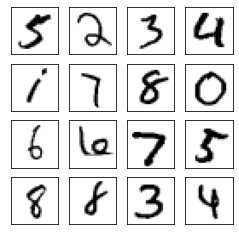

In [18]:
real_samples, mnist_labels = next(iter(train_dataloader))
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(4, 4),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in zip(range(16), axs.flat):
    ax.imshow(real_samples[i].reshape(28,28), cmap='gray_r')

In [20]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

discriminator = Discriminator().to(device=device)

In [21]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)

In [22]:
epochs = 50
lr = 0.0001
loss_function = nn.BCELoss()
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

for epoch in range(epochs):
    for n, (real_samples, _) in enumerate(train_dataloader):

        # generate data for the discriminator
        real_samples = real_samples.to(device)
        fake_samples = torch.randn((batch_size, 100)).to(device=device)
        fake_generated = generator(fake_samples)
        real_labels = torch.ones((batch_size, 1)).to(device=device)
        fake_labels = torch.zeros((batch_size, 1)).to(device=device)
        data_samples = torch.cat((real_samples, fake_generated))
        data_labels = torch.cat((real_labels, fake_labels))

        # train discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(data_samples)
        loss_discriminator = loss_function(output_discriminator, data_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # generate data for the generator
        fake_samples = torch.randn((batch_size, 100)).to(device=device)

        # train generator
        generator.zero_grad()
        output_generator = generator(fake_samples)
        output_discriminator_generated = discriminator(output_generator)
        loss_generator = loss_function(output_discriminator_generated, real_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # print loss and acc
        if n == batch_size - 1:
            print(f"Epoch: {epoch}")
            print(f"Loss Discriminator: {loss_discriminator}")
            print(f"Loss Generator: {loss_generator}")


Epoch: 0
Loss Discriminator: 0.5550225973129272
Loss Generator: 0.49410468339920044
Epoch: 1
Loss Discriminator: 0.04444970190525055
Loss Generator: 4.435750961303711
Epoch: 2
Loss Discriminator: 0.14580290019512177
Loss Generator: 3.9523940086364746
Epoch: 3
Loss Discriminator: 0.0024744709953665733
Loss Generator: 6.193818092346191
Epoch: 4
Loss Discriminator: 0.053666163235902786
Loss Generator: 5.928347587585449
Epoch: 5
Loss Discriminator: 0.060326628386974335
Loss Generator: 3.862772226333618
Epoch: 6
Loss Discriminator: 0.09328095614910126
Loss Generator: 3.6509499549865723
Epoch: 7
Loss Discriminator: 0.35175156593322754
Loss Generator: 2.8168797492980957
Epoch: 8
Loss Discriminator: 0.26196807622909546
Loss Generator: 2.5978190898895264
Epoch: 9
Loss Discriminator: 0.2462267279624939
Loss Generator: 2.275624990463257
Epoch: 10
Loss Discriminator: 0.3124767541885376
Loss Generator: 2.3687846660614014
Epoch: 11
Loss Discriminator: 0.4984309673309326
Loss Generator: 1.87547349929

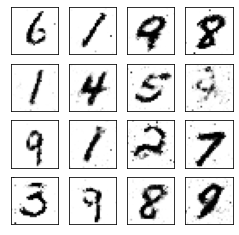

In [23]:
sample_test = torch.randn(batch_size, 100).to(device)
output_generated = generator(sample_test)
output_generated = output_generated.cpu().detach()
fig, axs = plt.subplots(4, 4, figsize=(4, 4),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in zip(range(16), axs.flat):
    ax.imshow(output_generated[i].reshape(28, 28), cmap='gray_r')